# Programming Assignment 3: Low Rank Matrix Approximation

<p>
    

<font size="3">

In this assignment, we will use low-rank approximation of matrices, which is useful for finding hidden relationships that might not be apparent from high-dimensional data.



**Assignment submission:** This assignment is to be uploaded as both a .ipynb file and a converted .pdf file **via Gradescope**. For help converting the notebook to a .pdf file, see [this document](https://bit.ly/cos324-colab-pdf). You can submit as often as you need, but only the last submission is graded, and submissions made after the deadline may incur a late penalty depending on your remaining free late hours.

## Collaboration statement

List all collaborators by name, including other students and/or course staff (e.g. TAs, UCAs). If you collaborated with no one on this assignment, write the following: ``"I did not collaborate with anyone on this assignment."``

**TODO: ADD COLLABATION STATEMENT HERE.**

<ins>Format of this PA:<ins>
1. Implement Low Rank Matrix Approximation (LORMA) (ACT 1-6)
2. Perform movie recommendation using LORMA (ACT 7-10)

<hr style="border:3px solid blue"> </hr>

## **Part 1: Implementing Low-Rank Matrix Approximation (LORMA)**

## Formal definition and notation

In this assignment you will be required to approximate a partially observed (typically) large matrix using a product of low rank matrices. Let us recap the ingredients of low rank matrix approximation:  <p>

- Observed matrix $\mathsf{M}$ of size $m \times n$ with real valued entries and missing values <p>
    
- Low rank matrices $\mathsf{A}$ of size $m \times k$ and $\mathsf{B}$ of size $k \times n$ <p>
    
- We would like to find $\mathsf{A}, \mathsf{B}$ such that $\mathsf{M} \approx \mathsf{A} \mathsf{B}$. We will denote $\hat{\mathsf{M}} = \mathsf{A}\mathsf{B}$ <p>
    
Let $\Omega$ denote the set of entries $(i,j)$ where we know the value of $\mathsf{M}_{ij}$. We are going to measure the goodness of our approximation using the squared error at entries $(i,j)$ in $\Omega$ (i.e., at observed entries of $\mathsf{M}$). Therefore the loss is,
$$ L = \frac{1}{|\Omega|} \sum_{(i,j)\in \Omega} \! \big(\mathsf{M}_{ij} -  \hat{\mathsf{M}}_{ij}\big)^2 ~. $$

### ACT1: Implement average squared loss function

In [1]:
import matplotlib.pyplot as plt
import numpy as np

# Given M, M_approx, O, return the average squared loss over the observed entries.
#
# parameters
# M:        m x n 2-D numpy array
#           containing the observed entries (with arbitrary values in the unobserved entries)
#
# M_approx: m x n 2-D numpy array
#           representing the low-dimensional approximation
#
# O:        m x n 2-D numpy array
#           containing 0 if the entry is unobserved and 1 if the entry is observed in M.
#           O tells you which entries in M were observed (corresponds to \Omega in the equations above)
#
# output
# loss:     average of squared loss over observed entries
#
# NOTE: No loops please! Your implementation must be vectorized. You may not use a python loop
def loss(M, M_approx, O):
    squaredloss_sum = np.sum((O*((M-M_approx)** 2)))
    O_sum = np.sum(O)
    avg_loss = squaredloss_sum / O_sum
    return avg_loss

# The following functions checks if your implementation of loss() is correct
# There's no need to understand it
def check_loss():
    M = np.array([[2, 4, 1], [1, -3, 1]])
    M_approx = np.zeros((2, 3))
    O = np.array([[1, 0, 0], [0, 1, 1]])
    answer = 14 / 3
    output = loss(M, M_approx, O)
    assert(np.isclose(answer, output))
    print("Function {} is working fine!".format('loss()'))

check_loss()

Function loss() is working fine!


<hr style="border:3px solid blue"> </hr>


## Normalization of M

As the initial prediction of $\hat{\mathsf{M}}$ is likely to have entries following a standard normal distribution and we use the squared error as the sole loss, it is good practice for us to normalize $\mathsf{M}$ prior to the learning process. This means that we will preprocess matrix $\mathsf{M}$ so the average over its observed entries is $0$ and the standard deviation is 1. Then the empirical distribution of its entries resembles a standard normal distribution.   

Mathematically speaking, let us normalize $\mathsf{M}$ such that,
$$\sum_{(i,j)\in \Omega} \mathsf{M}_{ij} = 0 ~ \text{ and } ~ \frac{1}{|\Omega|} \sum_{(i,j)\in \Omega} \mathsf{M}^2_{ij} = 1 ~ .$$

We first need to calculate $a$ and $s$, the mean and standard deviation respectively of the observed entries in $\mathsf{M}$:
$$a = \frac{1}{|\Omega|}\sum_{(i,j)\in O}\mathsf{M}_{ij} ~~ \text{ and } ~~ s = \sqrt{\frac{1}{|\Omega|} \sum_{(i,j)\in \Omega} (\mathsf{M}_{ij} - a)^2}.$$

Performing the transformation $\mathsf{M} \mapsto (\mathsf{M} - a) / s$ normalizes the matrix $\mathsf{M}$.

**Implementation note:** The function `get_normalized_matrix` should **not mutate** any of its parameters. You should **make a copy** of the relevant parameter(s) (i.e. using `np.copy`) and make changes to the copied variable(s).

### ACT2: Return the normalized version of M


In [2]:
# Given M, O, return the normalized version of M
#
# parameters
# M:        m x n 2-D numpy array
#           containing the observed entries (with arbitrary values in the unobserved entries)
#
# O:        m x n 2-D numpy array
#           containing 0 if the entry is unobserved and 1 if the entry is observed in M.
#           O tells you which entries in M were observed (corresponds to \Omega in the equations above)
#
# output
# M:        m x n 2-D numpy array
#           normalized copy of the input matrix M
#
# NOTE: No loops please! Your implementation must be vectorized. You may not use a python loop
def get_normalized_matrix(M, O):
    M_copy = np.copy(M)
    new_M = np.copy(M)
    O_copy = np.copy(O)

    mean_obs = (np.sum(O_copy * M_copy)) / np.sum(O_copy) #a

    std_obs = np.sqrt((np.sum(((M_copy - mean_obs) * O_copy) ** 2) / np.sum(O_copy))) #s

    new_M = (M - mean_obs)/std_obs

    return new_M
# The following functions checks if your implementation of get_normalized_matrix() is correct
# There's no need to understand it
def check_normalization():
    M = np.random.rand(10, 3)
    O = (np.random.rand(10, 3) > 0.5) + 0
    Mn = get_normalized_matrix(M, O)
    assert(abs(np.sum(M * O)) > 1e-6)
    assert(abs(np.sum(Mn * O)) < 1e-6)
    assert(abs(np.sum(Mn**2 * O) / np.sum(O) - 1) < 1e-6)
    print("Function {} is working fine!".format('get_normalized_matrix()'))

check_normalization()

Function get_normalized_matrix() is working fine!


<hr style="border:3px solid blue"> </hr>


## Low Rank Matrix Approximation (LORMA)

We are now ready to build a low rank approximation (abbreviated as *LORMA*) of the form,
$$
\mathsf{M} \approx \hat{\mathsf{M}} = \mathsf{A} \mathsf{B}  ~ .
$$
For brevity we refer to this model as *LORMA*. Note that once we established the approximating matrix $\hat{\mathsf{M}}$ we can reuse the same function **loss** from above.

### ACT3: Implement LORMA's prediction

In [3]:
# Given A, B, the low-rank matrices, calculate and return M_approx (M hat above)
#
# parameters
# A:        m x k 2-D numpy array
# B:        k x n 2-D numpy array
#
# output
# M_approx: m x n 2-D numpy array
#
# NOTE: No loops please! Your implementation must be vectorized. You may not use a python loop
# NOTE: Your implementation should be very simple, don't overthink it!
def lorma(A, B):
    approx = A @ B
    return approx

## Gradient of LORMA

Next we need to implement the gradient of the LORMA model. The gradient should have the same structure as the parameters of our LORMA model, which are A (shape $m \times k$) and B (shape $k \times n$).

To get the gradient to A, we apply chain rule for matrix differentiation as:
$$
\frac{dL}{d \mathsf{A}} = \frac{d L}{d \hat{\mathsf{M}}} \cdot \frac{d \hat{\mathsf{M}}}{d \mathsf{A}}
$$
where $\frac{dL}{d \hat{\mathsf{M}}}$ returns a matrix of a shape of $m \times n$ with its entries:
$$
(\frac{dL}{d \hat{\mathsf{M}}})_{ij} =
                \begin{cases}
                \frac{2}{|\Omega|}(\hat{\mathsf{M}}_{ij} - \mathsf{M}_{ij}) & \text{if} (i,j)\in \Omega \\
                0 & \text{otherwise}
                \end{cases}
$$
and
$$
\frac{d \hat{\mathsf{M}}}{d \mathsf{A}} = \mathsf{B}^T
$$
returns a matrix of shape $n \times k$. Note "$\cdot$" denotes the matrix multiplication.


Likewise, to get the gradient with respect to B, we have
$$
\frac{dL}{d \mathsf{B}} = \frac{d \hat{\mathsf{M}}}{d \mathsf{B}}  \cdot  \frac{dL}{d \hat{\mathsf{M}}} ~~~~~~\text{where}~~~~~  \frac{d \hat{\mathsf{M}}}{d \mathsf{B}} = \mathsf{A}^T
$$

### ACT4: Implement LORMA gradient

In [4]:
# Given M, O, A, B return dL/dA, dL/dB.
#
# parameters
# M:        m x n 2-D numpy array
#           containing the observed entries (with arbitrary values in the unobserved entries)
#
# O:        m x n 2-D numpy array
#           containing 0 if the entry is unobserved and 1 if the entry is observed in M.
#           O tells you which entries in M were observed (corresponds to \Omega in the equations above)
#
# A:        m x k 2-D numpy array
# B:        k x n 2-D numpy array
#
# output
# dL/dA:    m x k 2-D numpy array
# dL/dB:    k x n 2-D numpy array
#
# NOTE: No loops please! Your implementation must be vectorized. You may not use a python loop
def lorma_grad(M, O, A, B):
    Mcopy = np.copy(M)
    approx = lorma(A, B)

    #dL/dMhat
    dL_dMhat = (2 * O)*(approx - M) / np.sum(O)
    #dMhat/dA
    dmhat_dA = B.T
    #dL/dA
    dA = dL_dMhat @ dmhat_dA


    #dMhat/dB
    dmhat_dB = A.T
    #dL/dB
    dB = dmhat_dB @ dL_dMhat

    return dA, dB

## Initialization of LORMA

<p>

<font size=3>
    
Before we start learning using GD, we need to setup an initial state of $\mathsf{A}$ and $\mathsf{B}$ for estimating $\hat{\mathsf{M}}$. Recall we normalized $\mathsf{M}$ such that
$$\sum_{(i,j) \in \Omega} \mathsf{M}_{ij} = 0 ~ \text{ and } ~ \frac{1}{|\Omega|} \sum_{(i,j)\in \Omega} \mathsf{M}^2_{ij} = 1 ~ .$$
We would like to make sure that the similar properties hold for $\hat{\mathsf{M}}$.
<br><br>

More specifically, we adopt random initialzation of the entries in $\mathsf{A}$ and $\mathsf{B}$ followed by a normalization process to make $\hat{\mathsf{M}}$ satisfy the following properties:  
1. Zero mean, i.e., $\sum_{(i,j)\in \Omega} \hat{\mathsf{M}}_{ij} = 0$:
    
  We can write $\hat{\mathsf{M}}_{ij} = \mathbf{a}_i \cdot \mathbf{b}_j$ where $\mathbf{a}_i$ and $\mathbf{b}_j$ are the i'th row & j'th column of $\mathsf{A}$ and $\mathsf{B}$ respectively. Since $\mathsf{A}$ and $\mathsf{B}$ are completely random the probability that $\mathbf{a}_i\cdot \mathbf{b}_j$ is small is pretty high so we can assume that $\sum_{i,j} \hat{\mathsf{M}}_{ij} = \sum_{i,j} \mathbf{a}_i \cdot \mathbf{b}_j \approx 0$.


2. Less than or equal to unit variance, i.e., $\frac{1}{mn} \sum_{i,j} \hat{\mathsf{M}}_{ij}^2  \leq 1$:    
    
  It suffices to have each $|\hat{\mathsf{M}}_{ij}|\leq 1$ to satisfy the above condition.
  We can guarantee this by normalizing each $\mathbf{a}_i$ and $\mathbf{b}_j$ so they have a unit norm:
$$
    \mathbf{a}_i \mapsto \frac{\mathbf{a}_i}{\|\mathbf{a}_i\|} ~ \text{ and } ~
    \mathbf{b}_j \mapsto \frac{\mathbf{b}_j}{\|\mathbf{b}_j\|} ~ .
$$
Once the norm of all vectors $\mathbf{a}_1,\ldots,\mathbf{a}_k,\mathbf{b}_1,\ldots,\mathbf{b}_k$ is $1$ the inner products $\mathbf{a}_i\cdot \mathbf{b}_j$ are in $[-1,1]$, which tells us $| \hat{\mathsf{M}}_{ij}| \leq 1$. This property is known as Cauchy's inequality which is typically presented as,
$| \mathbf{a} \cdot \mathbf{b} | \leq \| \mathbf{a} \| \| \mathbf{b} \|$.

</font>


**NOTES**

*   The random values should be in a normal distribution with mean 0 and variance 1
*   For randomizing and creating arrays A and B, you can use any function under the `np.random` library that produces the required unit variance gaussian.





##ACT5: Implement LORMA initialization

In [5]:
# Given m, n, k, initialize and normalize A, B as per the guideline above
#
# parameters
# m, n, k:  shapes for A, B
#
# output
# A:        m x k 2-D numpy array
# B:        k x n 2-D numpy array
#
# NOTE: No loops please! Your implementation must be vectorized. You may not use a python loop
def lorma_init(m, n, k):
    # ACT5a: intialize A, B using a zero-mean unit-variance Gaussian (ie a normal distribution with mean 0 and variance 1) per entry
    A = np.random.randn(m, k)
    B = np.random.randn(k, n)
    # ACT5b: normalize the rows of A and columns of B
    A = A / np.linalg.norm(A, axis=1, keepdims=True)
    B = B / np.linalg.norm(B, axis=0, keepdims=True)
    return A, B

# The following code is to check your implementation
# There's no need to understand it
def check_lorma_init():
    A, B = lorma_init(10, 7, 3)
    assert(np.linalg.norm(np.diag(A @ A.T) - np.ones(10), 1) < 1e-6)
    assert(np.linalg.norm(np.diag(B.T @ B) - np.ones(7), 1) < 1e-6)
    print("Function {} is working fine!".format('lorma_init()'))
    return

check_lorma_init()

Function lorma_init() is working fine!


<hr style="border:3px solid blue"> </hr>


## Finally, it is time to use gradient descent (GD) to learn a LORMA model


<font size=3>
    
Details for implementation:
1. Unpack parameters in params (code provided)
2. Initialize A, B by calling lorma_init()
3. Create a list `losses` which will record the approximation error at every 10 epochs. Store the initial loss as `losses[0]`
4. Within the main loop
- Call lorma_grad() to get new gradients `dA` for `A` and `dB` for `B`
- Perform gradient step with the appropriate learning rate from the provided **list** `etas`
- Every 10 epochs, do the following
    - Call the loss() function to calculate and append the current loss to `losses`
    - Print the most recent current loss. Your print statements should be of the following format, where the loss rounded to 4 decimal places (recall that `arr[-1]` returns the last element in an list and `x.round(4)` rounds a number to 4 decimal places):
      ```
      Epoch 0: ____
      Epoch 10: ____
      Epoch 20: ____
      ...
      ```

### ACT6: Implement GD for LORMA model

In [6]:
# Given M, O, params, run gradient descent to compute the low-dimensional
# approximation A, B and losses, the list of approximation errors
#
# parameters
# M:        m x n 2-D numpy array
#           containing the observed entries (with arbitrary values in the unobserved entries)
#
# O:        m x n 2-D numpy array
#           containing 0 if the entry is unobserved and 1 if the entry is observed in M.
#           O tells you which entries in M were observed (corresponds to \Omega in the equations above)
#
# params:   tuple of 3 parameters (k, num_epochs, etas)
#.          k is the rank of your LORMA model
#           num_epochs is the number of epochs to run gradient descent
#           etas is a list of floats, with the learning rate for each epoch
#           len(etas) = num_epochs
#
# output
# A:        m x k 2-D numpy array
# B:        k x n 2-D numpy array
# losses:   list of approximation errors evaluated at every 10 epochs
def lorma_learn(M, O, params):
    k, num_epochs, etas = params
    ### ACT6: add your code here
    m, n = M.shape
    A, B = lorma_init(m, n, k)
    losses = []
    losses.append(loss(M, lorma(A, B), O))

    for e in range(num_epochs):
        dA, dB = lorma_grad(M, O, A, B)
        A -= etas[e] * dA
        B -= etas[e] * dB
        if e % 10 == 0:
          thisloss = loss(M, lorma(A,B), O)
          losses.append(thisloss)
          print("Epoch", e, ": ", thisloss)

    return A, B, losses

Epoch 0 :  131.84446978976473
Epoch 10 :  0.17306173640292502
Epoch 20 :  0.1126993160240386
Epoch 30 :  0.08286981177614593
Epoch 40 :  0.06554153040104196
Epoch 50 :  0.05459752717656124
Epoch 60 :  0.04726685427473142
Epoch 70 :  0.04213719564844912
Epoch 80 :  0.0384239644474877
Epoch 90 :  0.03566171775027005


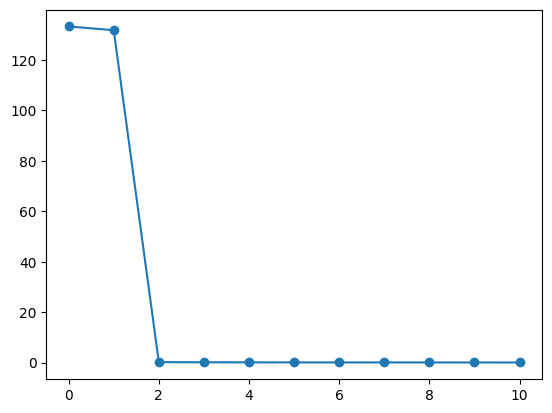

In [7]:
m, n, k = 100, 40, 5
rand_seed = 10
np.random.seed(rand_seed)

def check_lorma_learn():
    from numpy.random import binomial, randn, uniform
    mockA, mockB = uniform(1, 2, (m, k)), uniform(-2, -1, (k, n))
    M = mockA @ mockB + 0.01 * np.random.randn(m, n)
    O = binomial(1, 0.5, size=M.shape)
    num_epochs = 100
    etas = 2.0 * np.ones(num_epochs)
    params = k, num_epochs, etas
    A, B, losses = lorma_learn(M, O, params)
    plt.plot(losses, '-o')
    return M, A, B

M, A, B = check_lorma_learn()

### Visualizing the data matrix and it low-rank approximation

For reference let us also visualize a random matrix from the same distribution used for initialization.

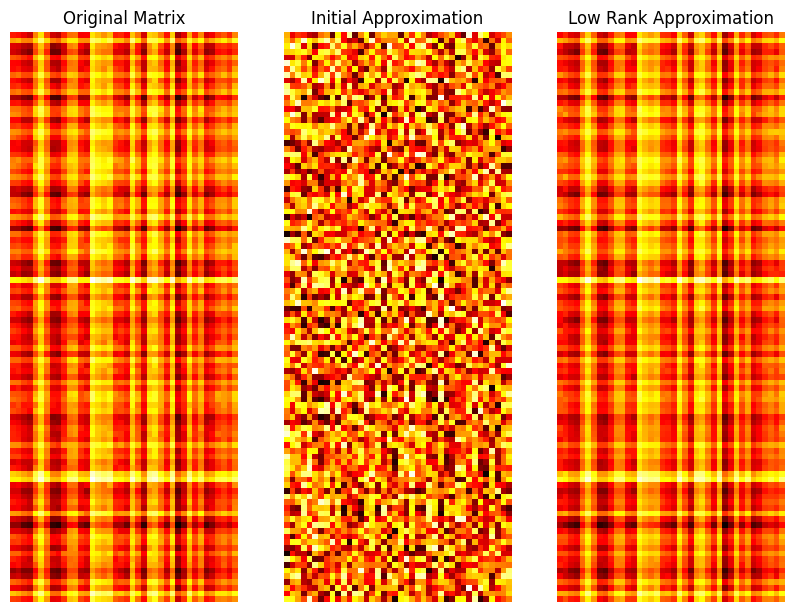

In [8]:
def show_mat(X, str, ind):
    plt.subplot(1,3,ind)
    plt.imshow(X, cmap='hot')
    plt.axis('off')
    plt.title(str)

Ar, Br = lorma_init(m, n, k)
fig = plt.figure(figsize=(10,60))
show_mat(M, 'Original Matrix', 1)
show_mat(lorma(Ar, Br), 'Initial Approximation', 2)
show_mat(lorma(A, B), 'Low Rank Approximation', 3)

<hr style="border:3px solid blue"> </hr>

## **Part 2: Movie Recommendation**

You are given data about users and their movie preferences, and you're tasked with recommending movies that the users have not seen and would like. In lecture, you learned about the [Netflix Prize](https://www.netflixprize.com), which awarded 1 million dollars to a team that  significantly improved their in-house movie recommendation system.

An interesting tidbit: The team that finished second in 2008 was comprised of three Princeton undergraduates! [[article]](https://www.cs.princeton.edu/news/article/princeton-undergraduates-challenge-1000000-netflix-prize)

### MovieLens dataset and Pandas library    
We will be using a smaller dataset called [MovieLens](https://grouplens.org/datasets/movielens/) and will be using the [pandas](https://pandas.pydata.org/) library (specifically [pandas.DataFrame](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.html)) to work with the dataset.

Because this is the first time we're using `pandas` in the course, we'll be breaking down the steps in more detail than usual and including a few conceptual questions along the way.

For answers to questions, **answer concisely** (complete sentences are not necessary).


## Act 7: Prepare the dataset
To prepare the dataset to run LORMA on it, you'll be using the following pandas functions:
- [pd.read_csv](https://pandas.pydata.org/docs/reference/api/pandas.read_csv.html)
- [pd.DataFrame.pivot](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.pivot.html)

## Act 7a: Download the MovieLens dataset

Use the [pd.read_csv](https://pandas.pydata.org/docs/reference/api/pandas.read_csv.html) to download the MovieLens dataset. Specifically, we'll be loading data from the `ratings.csv` file.

In [9]:
# Imports for loading and splitting data
from sklearn.model_selection import train_test_split
import pandas as pd

# Act 7a: Download the MovieLens dataset into a pandas dataframe (hint: use pd.read_csv) and display it
movie_ratings_path = 'https://raw.githubusercontent.com/ameet-1997/Machine-Learning/master/MovieLens/ratings.csv'
movielens_df = pd.read_csv(movie_ratings_path)
movielens_df.head(5) ### your code here # displays first 5 rows of dataframe

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


## Act 7b: `pd.read_csv` Questions

**Q1: How many rows and columns are in the dataframe?**

**Q1 Answer: 100,836 rows, 4 columns

**Q2: What are the columns in the dataframe (state each column name and your best guess as to what it stores)?**

**Q2 Answer: userId = which movie watcher; movieId = which movie watched; rating = the rating the user gave the movie; timestamp = the timestamp in the movie

**Q3: Explain the data stored in the first row (row index 0).**

**Q3 Answer: User 1 watched movie 1 and ranked it a 4.0

## Act 7c: Convert DataFrame to matrix
 Convert the dataframe into a matrix where the rows (i.e. index) are users, the columns are movies, and the values are ratings.

 Hint: Use the [pd.DataFrame.pivot](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.pivot.html) function on the dataframe (i.e. `movielens_df.pivot(...)`)

In [10]:
matrix_df = movielens_df.pivot(index='userId', columns='movieId', values='rating')
matrix_df.head(5)

movieId,1,2,3,4,5,6,7,8,9,10,...,193565,193567,193571,193573,193579,193581,193583,193585,193587,193609
userId,,,,,,,,,,,,,,,,,,,,,
1,4.0,NaN,4.0,NaN,NaN,4.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Act 7d: Data Preprocessing

**Why are there `NaN` values in the `matrix_df` dataframe?**

**Answer:**

It's important to preprocess the data to get it into the right format. Let's replace the `NaN` values with a default value of `-1`. (Hint: Use the [`pandas.DataFrame.fillna`](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.fillna.html) function).

Finally, let's convert the pandas DataFrame object into a 2D numpy array (i.e. a matrix). (Hint: Use the [`pandas.DataFrame.to_numpy`](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.to_numpy.html) function).

Tip: You can chain the above two commands together with Python dot notation (i.e. `<python object>.<function a>.<function b>`)

In [11]:
missing_value = -1
movielens_matrix = matrix_df.fillna(-1).to_numpy()
movielens_matrix

array([[ 4. , -1. ,  4. , ..., -1. , -1. , -1. ],
       [-1. , -1. , -1. , ..., -1. , -1. , -1. ],
       [-1. , -1. , -1. , ..., -1. , -1. , -1. ],
       ...,
       [ 2.5,  2. ,  2. , ..., -1. , -1. , -1. ],
       [ 3. , -1. , -1. , ..., -1. , -1. , -1. ],
       [ 5. , -1. , -1. , ..., -1. , -1. , -1. ]])

In [12]:
# check data processing step
def check_data_processing(M):
  assert(np.sum(M == -1) == 5830804)
  assert(M.shape[0] == 610)
  assert(M.shape[1] == 9724)
  assert(M.dtype == 'float64')
  assert(M[0][0] == 4)
  assert(M[0][1] == -1)
  print("Matrix passes basic data processing checks.")

check_data_processing(movielens_matrix)

Matrix passes basic data processing checks.


In the next cell, we provide the last data processing step.

We create an observed matrix called `movielens_observed` that stores a 1 where we have user ratings and a 0 otherwise.


In [13]:
# Create the observed matrix with 1s where we have user ratings for a given movie and 0s otherwise
movielens_observed = movielens_matrix != -1
movielens_observed = movielens_observed.astype(int)
print(movielens_observed)

[[1 0 1 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [1 1 1 ... 0 0 0]
 [1 0 0 ... 0 0 0]
 [1 0 0 ... 0 0 0]]


## Act 8: Run LORMA on the MovieLens dataset

Implement the following in the next code block:
1. Save a normalized version of the MovieLens data using `get_normalized_matrix`.
2. Define the parameters for LORMA (use rank = 40, epochs = 2000, eta = 10.0 for all epochs)
3. Run LORMA using the `lorma_learn` function
4. Plot losses to make sure they are decreasing.

**Hint:** Look at the function definition for `check_lorma_learn` for sample code on how to do steps 2-3.

**Note:** Running LORMA for 2000 epochs on the MovieLens dataset will take ~10 minutes in Colab.

Epoch 0 :  1.024160892484251
Epoch 10 :  1.015012390835472
Epoch 20 :  1.0066323001092896
Epoch 30 :  0.9987937378099734
Epoch 40 :  0.9913144965219683
Epoch 50 :  0.9840416142329911
Epoch 60 :  0.976840465499379
Epoch 70 :  0.9695868022972931
Epoch 80 :  0.9621608352325743
Epoch 90 :  0.9544428836446442
Epoch 100 :  0.9463104509620999
Epoch 110 :  0.9376368566726342
Epoch 120 :  0.9282917953362101
Epoch 130 :  0.9181443717703985
Epoch 140 :  0.9070692057441231
Epoch 150 :  0.8949559836035256
Epoch 160 :  0.8817222103535853
Epoch 170 :  0.8673278051605606
Epoch 180 :  0.851788739474387
Epoch 190 :  0.8351856884766362
Epoch 200 :  0.8176635632057422
Epoch 210 :  0.7994196273833297
Epoch 220 :  0.7806815856764017
Epoch 230 :  0.7616810314108562
Epoch 240 :  0.7426296260920178
Epoch 250 :  0.723703932191711
Epoch 260 :  0.7050407671118153
Epoch 270 :  0.6867408073821646
Epoch 280 :  0.6688761306673566
Epoch 290 :  0.6514978289373945
Epoch 300 :  0.6346416300745449
Epoch 310 :  0.618331236

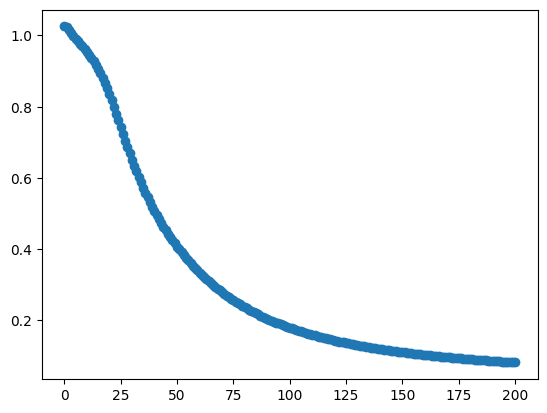

In [14]:
"""
Act 8: Run LORMA on the MovieLens dataset.
"""
rand_seed = 10
np.random.seed(rand_seed)

# 1. Normalize the copied matrix
movielens_normalized = get_normalized_matrix(movielens_matrix, movielens_observed)

# 2. Define the parameters for LORMA
k = 40
num_epochs = 2000
etas = 10.0 * np.ones(num_epochs)
params = k, num_epochs, etas

# 3. Run LORMA using the lorma_learn function
A, B, losses = lorma_learn(movielens_normalized, movielens_observed, params)

# 4. Plot the losses to make sure they are decreasing (given)
_ = plt.plot(losses, '-o')

## Act 9
In this final section, you'll analyze the movie preferences and predicted ratings for 3 users in our dataset (user 1, 13, and 111).

We provide most of the analysis code; you'll fill in a few statements related to accessing information from the dataset.

## Act 9a: Loading movie information dataset

In [15]:
# Load the movies
# The data consists of rows which are movie IDs
movie_info_path = 'https://raw.githubusercontent.com/ameet-1997/Machine-Learning/master/MovieLens/movies.csv'
movie_info_df = pd.read_csv(movie_info_path)
movie_info_df.head(5)

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


## Act 9b: User Analysis

In the next cell, you'll analyze the user data for 3 specific users.

For each of the 3 users, we first compute the top `p` (i.e. top 10) movies that were most highly rated by that user.

Then, in the inner for loop (`for movie in top_p`), store the movie title, user rating, and movie genre in their respective variables. Finally, you'll print out that information for the top `p` movies for that user.

### Hints:
- Use the [`.iloc`](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.iloc.html) function on `movie_info_df` to get the movie title and movie genre
- Get the user rating from the unnormalized matrix (i.e. `movielens_matrix`)

In [16]:
"""
We'll pick three users and see what movies they rated highly before, and what movies your model predicted.
Hopefully there is some correlation!

In this cell you will print out the top-p movies they rated most highly.
"""

# Pick three users to recommend movies to
users = [1, 13, 111]

# Let's see their tastes. Print the top-p movies they have rated highly
p = 10
for user in users:
    print("\nUser {} liked the following:\n".format(user))

    # Sort the movies for this user in descending order based on the rating
    movie_order = np.argsort(-movielens_matrix[user])
    top_p = movie_order[:p]

    # Print the top p movies
    for movie in top_p:
        # Store the movie title, user rating, and movie genre
        movie_title = movie_info_df.iloc[movie]['title']
        user_rating = movielens_matrix[user, movie]
        movie_genre = movie_info_df.iloc[movie]['genres']
        print("\t{:<50} rated {:.1f}  genres {:<30}".format(
            movie_title,
            user_rating,
            movie_genre))


User 1 liked the following:

	The Final Girls (2015)                             rated 5.0  genres Comedy|Horror                 
	Conan the Barbarian (2011)                         rated 5.0  genres Action|Adventure|Fantasy      
	I'm Still Here (2010)                              rated 5.0  genres Comedy|Drama                  
	The Hungover Games (2014)                          rated 5.0  genres Comedy                        
	Ender's Game (2013)                                rated 5.0  genres Action|Adventure|Sci-Fi|IMAX  
	Zombie Strippers! (2008)                           rated 5.0  genres Comedy|Horror                 
	10,000 BC (2008)                                   rated 4.5  genres Adventure|Romance|Thriller    
	For Richer or Poorer (1997)                        rated 4.5  genres Comedy                        
	Piranha (Piranha 3D) (2010)                        rated 4.5  genres Action|Horror|Thriller        
	Sunshine Cleaning (2008)                           rated 4.5

## Act 9c: Recommended Movies

In the next cell, you'll print out the top `p` (i.e. top 10) movies that are predicted for the 3 users we're studying.

For each of the 3 users, we first compute the predicted ratings for that user and save the top `p` predicted movies in descending order (we set the ratings for observed movies to -infinity so that we only save the top `p` movies that haven't been rated by the user).

Then, in the inner for loop (`for movie in top_p`), store the movie title and movie genre (this should be similar to what you did in Act 9b).

In [17]:
"""
User 1 seems to like Comedy and Horror
User 13 seems to like Drama and Romance
User 111 seems to like Sci-Fi and Adventure

Now let's make our predictions on the test data and see what movies we can recommend

"""

for user in users:
    print("\nRecommend the following movies to User {}\n".format(user))

    # Predict the rating for these movies by performing a matrix multiplication between the user and movie vectors
    predicted_ratings = A[user,:] @ B

    # If the movie review was observed in the matrix, set it to (-infinity) so that we don't predict it
    # We want to predict only from a set of movies which the user has not seen
    predicted_ratings[movielens_observed[user]] = -np.inf

    # Choose the top_p movies
    predicted_movie_order = np.argsort(-predicted_ratings)
    top_p = predicted_movie_order[:p]

    # Print the recommended movies
    for movie in top_p:
      movie_title = movie_info_df.iloc[movie]['title']
      movie_genre = movie_info_df.iloc[movie]['genres']

      print("\t{:<60} genres {:<30}".format(movie_title[:60], # cap length of movie title to 60 char
                                            movie_genre))


Recommend the following movies to User 1

	Cruise, The (1998)                                           genres Documentary                   
	Rumble in the Bronx (Hont faan kui) (1995)                   genres Action|Adventure|Comedy|Crime 
	Robin Hood: Men in Tights (1993)                             genres Comedy                        
	Corporation, The (2003)                                      genres Documentary                   
	Clueless (1995)                                              genres Comedy|Romance                
	Wallace & Gromit: The Best of Aardman Animation (1996)       genres Adventure|Animation|Comedy    
	Leaving Las Vegas (1995)                                     genres Drama|Romance                 
	Fried Green Tomatoes (1991)                                  genres Comedy|Crime|Drama            
	Conan the Barbarian (2011)                                   genres Action|Adventure|Fantasy      
	Ghosts of Mississippi (1996)                            

## ACT10: Answer the following question in the cell below

**Question:** Do you see any correlation between the top rated movies (Act 9b) and the top predicted movies (Act 9c)?

**For each user**, answer the question and briefly explain your reasoning in **1 sentence (total 3 sentences; 1 per user).**

For each user,
- If yes, briefly explain the correlation you observe.
- If no, briefly explain why you don't believe there's a correlation between their top rated movies and top predicted movies.

**Note:** The correlation, if there's any, may be weak.

**Answer: User 1 seems to have a comedy correlation in their recommendations. User 13 shows a stronger correlation for drama and romance films. User 111 seems to have a weaker correlation, perhaps because their watched films are at the intersection of so many categories, contrasting the previous users.